## *English to Danish Neural Machine Translation* 

This notebook will show you how to use GRUs for English to Danish Neural Machine Translation.

## Using Google GPU for Training

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected. 

In [2]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!')   

Found GPU at : /device:GPU:0


### **1. Flowchart**

The following flowchart shows roughly how the neural network is constructed. It is split into two parts: An encoder which maps the source-text to a "thought vector" that summarizes the text's contents, which is then input to the second part of the neural network that decodes the "thought vector" to the destination-text.


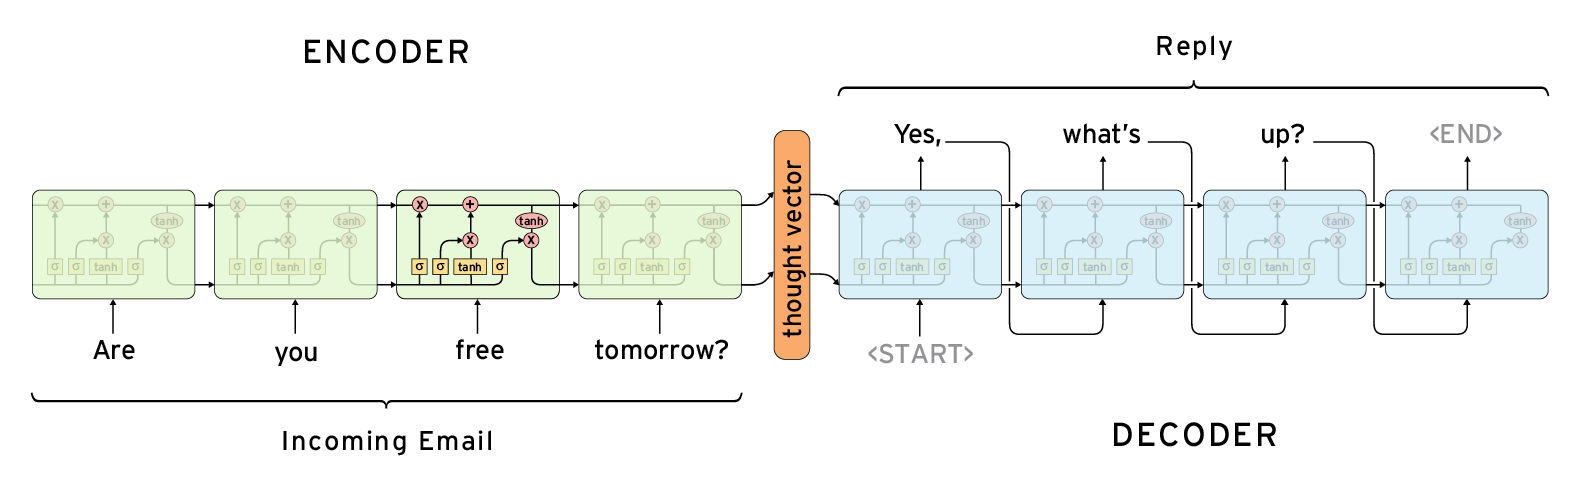

The neural network cannot work directly on text so first we need to convert each word to an integer-token using a tokenizer. But the neural network cannot work on integers either, so we use a so-called Embedding Layer to convert each integer-token to a vector of floating-point values. The embedding is trained alongside the rest of the neural network to map words with similar semantic meaning to similar vectors of floating-point values.

For example, consider the Danish text "der var engang" which is the beginning of any fairytale and literally means "there was once" but is commonly translated into English as "once upon a time". We first convert the entire data-set to integer-tokens so the text "der var engang" becomes [12, 54, 1097]. Each of these integer-tokens is then mapped to an embedding-vector with e.g. 128 elements, so the integer-token 12 could for example become [0.12, -0.56, ..., 1.19] and the integer-token 54 could for example become [0.39, 0.09, ..., -0.12]. These embedding-vectors can then be input to the Recurrent Neural Network, which has 3 GRU-layers.

The last GRU-layer outputs a single vector - the "thought vector" that summarizes the contents of the source-text - which is then used as the initial state of the GRU-units in the decoder-part.

The destination-text "once upon a time" is padded with special markers "ssss" and "eeee" to indicate its beginning and end, so the sequence of integer-tokens becomes [2, 337, 640, 9, 79, 3]. During training, the decoder will be given this entire sequence as input and the desired output sequence is [337, 640, 9, 79, 3] which is the same sequence but time-shifted one step. We are trying to teach the decoder to map the "thought vector" and the start-token "ssss" (integer 2) to the next word "once" (integer 337), and then map the word "once" to the word "upon" (integer 640), and so forth.

This flow-chart depicts the main idea but does not show all the necessary details e.g. regarding the loss function which is also somewhat complicated. 





### **2. Imports**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os 

We need to import several things from Keras. 

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

### **3. Inspect and Retrieve Dataset**

We will use the Europarl data-set which has sentence-pairs in most European languages. The data was created by the European Union which translates a lot of their communications to the languages of the member-countries of the European Union.

http://www.statmt.org/europarl/

In [5]:
!gdown --id 1M7Yyu_fMF3qh7-VBDhCpuSFBjKif0HWt
!gdown --id 1B8pOon8KxG-Swt3WkROE9meg0360wOd0

Downloading...
From: https://drive.google.com/uc?id=1M7Yyu_fMF3qh7-VBDhCpuSFBjKif0HWt
To: /content/europarl-v7.da-en.da
296MB [00:03, 94.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B8pOon8KxG-Swt3WkROE9meg0360wOd0
To: /content/europarl-v7.da-en.en
292MB [00:03, 82.6MB/s]


In this tutorial I have used the English-Danish data-set which contains about 2 million sentence-pairs. You can use another language in this [download link](http://www.statmt.org/europarl/v7/). 

In [6]:
data_dir = "/content"
language_code="da"

In order for the decoder to know when to begin and end a sentence, we need to mark the start and end of each sentence with words that most likely don't occur in the data-set.

In [7]:
mark_start = 'ssss '
mark_end = ' eeee'

I have written a helper function will parse the filename, open it and read all the content.

In [8]:
def load_data(english=True, language_code="da", start="", end=""):
    """
    Load the data-file for either the English-language texts or
    for the other language (e.g. "da" for Danish).
    All lines of the data-file are returned as a list of strings.
    :param english:
      Boolean whether to load the data-file for
      English (True) or the other language (False).
    :param language_code:
      Two-char code for the other language e.g. "da" for Danish.
      See list of available codes above.
    :param start:
      Prepend each line with this text e.g. "ssss " to indicate start of line.
    :param end:
      Append each line with this text e.g. " eeee" to indicate end of line.
    :return:
      List of strings with all the lines of the data-file.
    """

    if english:
        # Load the English data.
        filename = "europarl-v7.{0}-en.en".format(language_code)
    else:
        # Load the other language.
        filename = "europarl-v7.{0}-en.{0}".format(language_code)

    # Full path for the data-file.
    path = os.path.join(data_dir, filename)

    # Open and read all the contents of the data-file.
    with open(path, encoding="utf-8") as file:
        # Read the line from file, strip leading and trailing whitespace,
        # prepend the start-text and append the end-text.
        texts = [start + line.strip() + end for line in file]

    return texts

Load the texts for the destination-language, here we use English.

In [9]:
data_src = load_data(english=True,
                    language_code=language_code)

Load the texts for the source-language, here we use Danish.

In [10]:
data_dest = load_data(english=False,
                     language_code=language_code,
                     start=mark_start,
                     end=mark_end)

### **3. Example Data**

The data is just a list of texts that is ordered so the source and destination texts match. I can confirm that this example is an accurate translation.

In [11]:
data_src[2]

"Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."

In [12]:
data_dest[2]

'ssss Som De kan se, indfandt det store "år 2000-problem" sig ikke. Til gengæld har borgerne i en del af medlemslandene været ramt af meget forfærdelige naturkatastrofer. eeee'

### **4. Tokenizer**

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the data-set. We use the same number for both the source and destination languages, but these could be different.

In [13]:
num_words = 10000 

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it. 

In [14]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            # Reverse the token-sequences.
            self.tokens = [list(reversed(x)) for x in self.tokens]
        
            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        # The number of integer-tokens in each sequence.
        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        # This is a compromise so we save a lot of memory and
        # only have to truncate maybe 5% of all the sequences.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)

        # Pad / truncate all token-sequences to the given length.
        # This creates a 2-dim numpy matrix that is easier to use.
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            # Reverse the tokens.
            tokens = np.flip(tokens, axis=1)

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        if padding:
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)

        return tokens 

Now create a tokenizer for the source-language. Note that we pad zeros at the beginning ('pre') of the sequences. We also reverse the sequences of tokens because the research literature suggests that this might improve performance, because the last words seen by the encoder match the first words produced by the decoder, so short-term dependencies are supposedly modelled more accurately. 

In [15]:
%%time
tokenizer_src = TokenizerWrap(texts=data_src,
                              padding='pre',
                              reverse=True,
                              num_words=num_words) 

CPU times: user 1min 32s, sys: 815 ms, total: 1min 33s
Wall time: 1min 33s


Now create the tokenizer for the destination language. We need a tokenizer for both the source- and destination-languages because their vocabularies are different. Note that this tokenizer does not reverse the sequences and it pads zeros at the end ('post') of the arrays.

In [16]:
%%time
tokenizer_dest = TokenizerWrap(texts=data_dest,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

CPU times: user 2min 5s, sys: 586 ms, total: 2min 5s
Wall time: 2min 5s



Define convenience variables for the padded token sequences. These are just 2-dimensional numpy arrays of integer-tokens.

Note that the sequence-lengths are different for the source and destination languages. This is because texts with the same meaning may have different numbers of words in the two languages.

Furthermore, we have made a compromise when tokenizing the original texts in order to save a lot of memory. This means we only truncate about 5% of the texts. 

In [17]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src.shape)
print(tokens_dest.shape) 

(1968800, 53)
(1968800, 49)



This is the integer-token used to mark the beginning of a text in the destination-language.

In [18]:
token_start = tokenizer_dest.word_index[mark_start.strip()]
token_start 

1


This is the integer-token used to mark the end of a text in the destination-language. 

In [19]:
token_end = tokenizer_dest.word_index[mark_end.strip()]
token_end 

2

### **5. Training Data**

Now that the data-set has been converted to sequences of integer-tokens that are padded and truncated and saved in numpy arrays, we can easily prepare the data for use in training the neural network.

The input to the encoder is merely the numpy array for the padded and truncated sequences of integer-tokens produced by the tokenizer:

In [20]:
encoder_input_data = tokens_src 

The input and output data for the decoder is identical, except shifted one time-step. We can use the same numpy array to save memory by slicing it, which merely creates different 'views' of the same data in memory.

In [21]:
decoder_input_data = tokens_dest[:, :-1]
decoder_input_data.shape 

(1968800, 48)

In [22]:
decoder_output_data = tokens_dest[:, 1:]
decoder_output_data.shape 

(1968800, 48)


For example, these token-sequences are identical except they are shifted one time-step. 

In [23]:
decoder_input_data[2] 

array([   1,   15,   12,   26,  168,    7,  138,   71,  501,  287,   41,
         22,   10, 2078,   21,  304,    5,   11,  180,    9, 1997,  110,
       1388,    9,   45, 3376, 3071,    2,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [24]:
decoder_output_data[2]

array([  15,   12,   26,  168,    7,  138,   71,  501,  287,   41,   22,
         10, 2078,   21,  304,    5,   11,  180,    9, 1997,  110, 1388,
          9,   45, 3376, 3071,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

### **6. Create the Neural Network**

###*Create the Encoder*
First we create the encoder-part of the neural network which maps a sequence of integer-tokens to a "thought vector". We will use the so-called functional API of Keras for this, where we first create the objects for all the layers of the neural network and then we connect them later, this allows for more flexibility than the so-called sequential API in Keras, which is useful when experimenting with more complicated architectures and ways of connecting the encoder and decoder.

This is the input for the encoder which takes batches of integer-token sequences. The None indicates that the sequences can have arbitrary length. 

In [25]:
encoder_input = Input(shape=(None, ), name='encoder_input') 


This is the length of the vectors output by the embedding-layer, which maps integer-tokens to vectors of values roughly between -1 and 1, so that words that have similar semantic meanings are mapped to vectors that are similar.

In [26]:
embedding_size = 128   #can be changed to 256, 512

This is the embedding-layer.

In [27]:
encoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='encoder_embedding')

This is the size of the internal states of the Gated Recurrent Units (GRU). The same size is used in both the encoder and decoder.

In [28]:
state_size = 512 


This creates the 3 GRU layers that will map from a sequence of embedding-vectors to a single "thought vector" which summarizes the contents of the input-text. Note that the last GRU-layer does not return a sequence.

In [29]:
encoder_gru1 = GRU(state_size, name='encoder_gru1',
                   return_sequences=True)
encoder_gru2 = GRU(state_size, name='encoder_gru2',
                   return_sequences=True)
encoder_gru3 = GRU(state_size, name='encoder_gru3',
                   return_sequences=False)

This helper-function connects all the layers of the encoder.

In [30]:
def connect_encoder():
    # Start the neural network with its input-layer.
    net = encoder_input
    
    # Connect the embedding-layer.
    net = encoder_embedding(net)

    # Connect all the GRU-layers.
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    net = encoder_gru3(net)

    # This is the output of the encoder.
    encoder_output = net
    
    return encoder_output 

Note how the encoder uses the normal output from its last GRU-layer as the "thought vector". Research papers often use the internal state of the encoder's last recurrent layer as the "thought vector". But this makes the implementation more complicated and is not necessary when using the GRU. But if you were using the LSTM instead then it is necessary to use the LSTM's internal states as the "thought vector" because it actually has two internal vectors, which we would need to initialize the two internal states of the decoder's LSTM units.

We can now use this function to connect all the layers in the encoder so it can be connected to the decoder further below.

In [31]:
encoder_output = connect_encoder() 

###*Create the Decoder*
Create the decoder-part which maps the "thought vector" to a sequence of integer-tokens.

The decoder takes two inputs. First it needs the "thought vector" produced by the encoder which summarizes the contents of the input-text.

In [32]:
decoder_initial_state = Input(shape=(state_size,),
                              name='decoder_initial_state') 

The decoder also needs a sequence of integer-tokens as inputs. During training we will supply this with a full sequence of integer-tokens e.g. corresponding to the text "ssss once upon a time eeee".

During inference when we are translating new input-texts, we will start by feeding a sequence with just one integer-token for "ssss" which marks the beginning of a text, and combined with the "thought vector" from the encoder, the decoder will hopefully be able to produce the correct next word e.g. "once".

In [33]:
decoder_input = Input(shape=(None, ), name='decoder_input') 


This is the embedding-layer which converts integer-tokens to vectors of real-valued numbers roughly between -1 and 1. Note that we have different embedding-layers for the encoder and decoder because we have two different vocabularies and two different tokenizers for the source and destination languages.

In [34]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding') 

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [35]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True) 

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length state_size. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

In [36]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output') 

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to route different inputs to the decoder. This is useful because we have to connect the decoder directly to the encoder, but we will also connect the decoder to another input so we can run it separately.

This function connects all the layers of the decoder to some input of the initial-state values for the GRU layers.

In [37]:
def connect_decoder(initial_state):
    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU-layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output 

### *Connect and Create the Models*

We can now connect the encoder and decoder in different ways.

First we connect the encoder directly to the decoder so it is one whole model that can be trained end-to-end. This means the initial-state of the decoder's GRU units are set to the output of the encoder.

In [38]:
decoder_output = connect_decoder(initial_state=encoder_output)

model_train = Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output]) 


Then we create a model for just the encoder alone. This is useful for mapping a sequence of integer-tokens to a "thought-vector" summarizing its contents.

In [39]:
model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output]) 


Note that all these models use the same weights and variables of the encoder and decoder. We are merely changing how they are connected. So once the entire model has been trained, we can run the encoder and decoder models separately with the trained weights

In [40]:
decoder_output = connect_decoder(initial_state=decoder_initial_state)

model_decoder = Model(inputs=[decoder_input, decoder_initial_state],
                      outputs=[decoder_output]) 

###*Compile the Model*
The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We have used the Adam optimizer in many of the previous tutorials, but it seems to diverge in some of these experiments with Recurrent Neural Networks. RMSprop seems to work much better for these.

In [41]:
model_train.compile(optimizer=RMSprop(lr=1e-3), #can use 2e-3 and 5e-3
                    loss='sparse_categorical_crossentropy') 

### **7. Callback Functions**


During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [42]:
path_checkpoint = 'nmt_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [43]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1) 

This is the callback for writing the TensorBoard log during training.

In [44]:
callback_tensorboard = TensorBoard(log_dir='./nmt_logs/',
                                   histogram_freq=0,
                                   write_graph=False) 

Let's set the callbacks which we'll use for training our model.

In [45]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard] 

### **8. Load Checkpoint**
You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

> NOTE: will execute only after training. To reuse model for later or transfer learning methods.

In [58]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error) 

### **9. Train the Model**
We wrap the data in named dicts so we are sure the data is assigned correctly to the inputs and outputs of the model.

In [46]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [47]:
y_data = \
{
    'decoder_output': decoder_output_data
} 

We want a validation-set of 10000 sequences but Keras needs this number as a fraction.

In [48]:
validation_split = 10000 / len(encoder_input_data)
validation_split 

0.0050792360828931325

Now we can train the model. One epoch of training took about 1 hour on a Google Colab GPU. You probably need to run 10 epochs or more during training. After 10 epochs the loss was about 1.10 on the training-set and about 1.15 on the validation-set.

The batch-size was chosen to keep the GPU running at nearly 100% while being within the memory limits of 8GB for this GPU.

In [49]:
model_train.fit(x=x_data,
                y=y_data,
                batch_size=384,
                epochs=1, #change to 10 or more for best results
                validation_split=validation_split,
                callbacks=callbacks) 

   1/5102 [..............................] - ETA: 0s - loss: 9.2109WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5102/5102 [==============================] - ETA: 0s - loss: 1.9083
Epoch 00001: val_loss improved from inf to 1.58161, saving model to nmt_checkpoint.keras
5102/5102 [==============================] - 3948s 774ms/step - loss: 1.9083 - val_loss: 1.5816


### **10. Translate Texts**
This function translates a text from the source-language to the destination-language and optionally prints a true translation.

In [50]:
def translate(input_text, true_output_text=None):
    """Translate a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                reverse=True,
                                                padding=True)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state = model_encoder.predict(input_tokens)

    # Max number of tokens / words in the output sequence.
    max_tokens = tokenizer_dest.max_tokens

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'decoder_initial_state': initial_state,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0, count_tokens, :]
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    
    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()

    # Print the translated output-text.
    print("Translated text:")
    print(output_text)
    print()

    # Optionally print the true translated text.
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()

### **11. Examples**
Translate a text from the training-data. This translation is quite good. Note how it is not identical to the translation from the training-data, but the actual meaning is similar.

In [51]:
idx = 3
translate(input_text=data_src[idx],
          true_output_text=data_dest[idx])

Input text:
You have requested a debate on this subject in the course of the next few days, during this part-session.

Translated text:
 de har bedt om en forhandling om dette spørgsmål i aften eeee

True output text:
ssss De har udtrykt ønske om en debat om dette emne i løbet af mødeperioden. eeee




In this example we join two texts from the training-set. The model first sends this combined text through the encoder, which produces a "thought-vector" that seems to summarize both texts reasonably well so the decoder can produce a reasonable translation. 

In [52]:
idx = 3
translate(input_text=data_src[idx] + data_src[idx+1],
          true_output_text=data_dest[idx] + data_dest[idx+1]) 

Input text:
You have requested a debate on this subject in the course of the next few days, during this part-session.In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.

Translated text:
 de har bedt om en af de der har været i denne forhandling som jeg har bedt om at tage ordet til fornyet overvejelse af de spørgsmål der er blevet fremsat af de grønne der er blevet nævnt af de seneste grupper i de seneste par måneder har jeg

True output text:
ssss De har udtrykt ønske om en debat om dette emne i løbet af mødeperioden. eeeessss I mellemtiden ønsker jeg - som også en del kolleger har anmodet om - at vi iagttager et minuts stilhed til minde om ofrene for bl.a. stormene i de medlemslande, der blev ramt. eeee



This is a sample text. However the translation is probably so broken because several of the words are not in the vocabulary.

In [57]:
translate(input_text="I love coding",
          true_output_text="jeg elsker kodning")

Input text:
I love coding

Translated text:
 jeg har eeee

True output text:
jeg elsker kodning



###**12. Conclusion**
This tutorial showed the basic idea of using two Gated Recurrent Units in a so-called encoder/decoder model to do Machine Translation of human languages. It was demonstrated on the very large Europarl data-set from the European Union.

The model could produce reasonable translations for some texts but not for others. It is possible that a better architecture for the neural network and more training epochs could improve performance. There are also more advanced models that are known to improve quality of the translations.

However, it is important to note that these models do not really understand human language. The models have no knowledge of the actual meaning of the words. The models are merely very advanced function approximators that can map between sequences of integer-tokens.

### **13. Exercises**
These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.


- Train for more than 10 epochs. Does it improve the translations?
- Increase the size of the vocabulary. Does it improve the translations? Would it make sense to have different sizes for the vocabularies of the source and destination languages?
- Find another data-set and use it together with Europarl.
- Change the architectures of the neural network, for example change the state-size for the GRU layers, the number of GRU layers, the embedding-size, etc. Does it improve the translations?
- Use hyper-parameter optimization to automatically find the best hyper-parameters.
- When translating texts, instead of using np.argmax() to sample the next integer-token, could you sample the decoder's output as if it was a probability distribution instead? Note that the decoder's output is not softmax-limited so you have to do that first to turn it into a probability-distribution.
- Can you generate multiple sequences by doing this sampling? Can you find a way to select the best of these different sequences?
- Disable the reversal of words for the source-language. Does it improve the translations?
- What is a Bi-Directional GRU and can you use it here?
= We use the output of the encoder's GRU as the initial state of the decoder's GRU. The research literature often uses an LSTM instead of the GRU, so they used the encoder's state instead of its output as the initial state of the decoder. Can you rewrite this code to use the encoder's state as the decoder's initial state? Is there a reason to do this, or is the encoder's output sufficient to use as the decoder's initial state?
- Is it possible to connect multiple encoders and decoders in a single neural network, so that you can train it on different languages and allow for direct translation e.g. from Danish to Polish, German and French?
- Explain to a friend how the program works.